## Import


In [1]:
from skimage.io import imread, imshow
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import progressbar
import time
from collections import Counter
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Projet/code

/content/drive/MyDrive/Projet/code


## Dataset Class

In [ ]:
class Dataset:
  def __init__(self, data):
    self.size = len(data['image'])
    self.image = data['image']
    self.cropcode = data['cropcode']

    self.img_train = []
    self.img_test = []
    self.code_train = []
    self.code_test = []

    self.print_info()
    self.separate_train_test()

  def print_info(self):
    c = Counter(self.cropcode)
    print("ww = Winter wheat" + '\n' +
          "sb = Spring barley" + '\n' +
          "sw = Spring Wheat" + '\n' +
          "wb = Winter barley" + '\n' +
          "be = Beet (sugar beet / fodder beet)" + '\n' +
          "fb = Field beans" + '\n' +
          "ma = Maize" + '\n' +
          "or = Oilseed rape" + '\n' +
          "po = Potatoes" + '\n' +
          "gr = Grass" + '\n' +
          "ot = Other crops" + '\n' + # i may reject this data
          "pe = Peas" + '\n' +
          "wo = Winter oats")
    key_value = {}
    for i in sorted(c.keys()):
          key_value[i] = c[i]

    plt.bar(key_value.keys(), key_value.values())
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of crops types')
    plt.show()

  def separate_train_test(self):
    self.img_train, self.img_test, self.code_train, self.code_test = train_test_split(self.image, self.cropcode, test_size=0.2)

    # data normalization
    #TODO
    print('Size of training set : ' + str(len(self.code_train)) + ' / ' + str(len(self.cropcode)))
    print('Size of testing set : ' + str(len(self.code_test))+ ' / ' + str(len(self.cropcode)))
    self.display_train_test()

  def display_train_test(self):
    test = Counter(self.code_test)
    train = Counter(self.code_train)
    info = "Dataset size " + str(self.size)

    key_value_train = {};
    key_value_test = {};

    for i in sorted(test.keys()):
      key_value_test[i] = test[i]
    for i in sorted(train.keys()):
      key_value_train[i] = train[i]

    p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
    p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) );

    plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of training and testing sets')
    plt.show()


## Data selection

In [ ]:
def plot_data(data):
  plt.bar(data.keys(), data.values());
  plt.xlabel('Labels')
  plt.ylabel('Occurrence')
  plt.title('Occurrence of crops types')
  plt.show()

In [ ]:
def equalize(gj):
  types = []
  for f in gj['features']:
    types.append(f['properties']['crop_code'])
  c = Counter(types)
  key_value = {}
  for i in c.keys():
    key_value[i] = c[i]

  val = key_value.values()
  key = key_value.keys()

  print(key)
  print(val)
  print()

  print("Choose an interval")
  print("lower limit")
  low = int(input())
  print("upper limit")
  up = int(input())

  for k in key_value:
    v = key_value[k]
    if v<low:
      key_value[k]=0
    else:
      rd = random.randint(low, up)
      if v<rd:
        key_value[k]=v
      else:
        key_value[k]=rd
  print(key_value)

  key_value['ot']=0
  plot_data(key_value)
  return key_value

In [ ]:
def get_data(gj):
  count = equalize(gj)
  image = []
  cropcode =[]

  idx=0;
  bar = progressbar.ProgressBar(maxval=len(gj['features'])).start()
  for f in gj['features']:
    cc = f['properties']['crop_code']
    gid = f['properties']['gid']

    if count[cc]!=0:
      if os.path.exists('DataSet/Prepared_Train_Dataset/Shapes/20190510/'+gid+'.tif'):
        cropcode.append(cc)
        img = imread('DataSet/Prepared_Train_Dataset/Shapes/20190510/'+gid+'.tif')
        image.append(img)
        count[cc] = count[cc] - 1
    idx +=1;
    bar.update(idx)
  data = {'image' : image, 'cropcode' : cropcode}
  return data

In [ ]:
with open('DataSet/Digimap_data/Train_labels_epsg_32630.geojson') as f:
    gj = json.load(f)

dict_keys(['po', 'or', 'pe', 'gr', 'ot', 'fb', 'sb', 'sw', 'wb', 'wo', 'ww'])
dict_values([226, 456, 8, 9413, 754, 34, 4560, 536, 876, 24, 560])

Choose an interval
lower limit
226
upper limit
250
{'po': 226, 'or': 250, 'pe': 0, 'gr': 233, 'ot': 234, 'fb': 0, 'sb': 250, 'sw': 250, 'wb': 246, 'wo': 0, 'ww': 236}


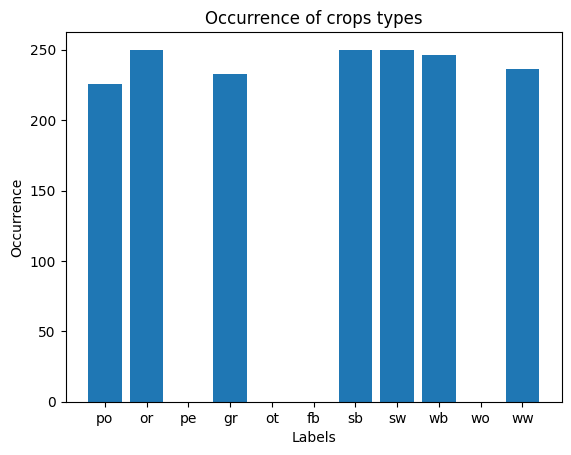

  0% (0 of 17447) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

KeyboardInterrupt: ignored

In [ ]:
data = get_data(gj)

In [ ]:
np.savez("DataSet/data_12_11.npz", image=data['image'], cropcode=data['cropcode'])

In [ ]:
data_l = np.load("DataSet/data_12_11.npz",allow_pickle=True)

## Data select without clouds

In [4]:
def plot_data(data):
  plt.bar(data.keys(), data.values());
  plt.xlabel('Labels')
  plt.ylabel('Occurrence')
  plt.title('Occurrence of crops types')
  plt.show()

def getData_noClouds(gj, cover_perc, fold_path):
  data_set = {"image":[], "cropcode":[]}

  idx=0;
  bar = progressbar.ProgressBar(maxval=len(gj['features'])).start()
  for f in gj['features']:
    cc = f['properties']['crop_code']
    gid = f['properties']['gid']
    path = fold_path+gid+'.tif'
    if os.path.exists(path):
      img = imread(path)
      mask = img[:, :, 16]
      nb_cloud_pix = np.count_nonzero(mask == 255)
      nb_non_cloud_pix = np.count_nonzero(mask == 0)
      if ((nb_cloud_pix/(nb_cloud_pix+nb_non_cloud_pix)*100) < cover_perc):
        for i in range(len(mask)):
          for j in range(len(mask[0])):
            if mask[i][j] == 255:
              img[i,j, [3, 2, 1, 7]]=[np.nan, np.nan, np.nan, np.nan]
        data_set['image'].append(img)
        data_set['cropcode'].append(cc)
    idx +=1;
    bar.update(idx)
  return data_set

def equalize(data_set):
  c = Counter(data_set['cropcode'])
  key_value = {}
  for i in c.keys():
    key_value[i] = c[i]

  plot_data(key_value)

  print(key_value.keys())
  print(key_value.values())
  print()

  print("Choose an interval")
  print("lower limit")
  low = int(input())
  print("upper limit at 10%")
  up = int(low+low*0.1)
  print(up)

  for k in key_value:
    v = key_value[k]
    if v<low:
      key_value[k]=0
    else:
      rd = random.randint(low, up)
      if v<rd:
        key_value[k]=v
      else:
        key_value[k]=rd

  key_value['ot']=0
  print(key_value)
  plot_data(key_value)

  count = key_value
  cropcode = []
  image = []
  idx=0;
  bar = progressbar.ProgressBar(maxval=len(data_set['cropcode'])).start()
  for f in range(len(data_set['cropcode'])):
    cc = data_set['cropcode'][f]
    img = data_set['image'][f]
    if count[cc]!=0:
      cropcode.append(cc)
      image.append(img)
      count[cc] = count[cc] - 1
    idx +=1;
    bar.update(idx)
  data = {'image' : image, 'cropcode' : cropcode}
  return data



In [5]:
with open('DataSet/Digimap_data/Train_labels_epsg_32630.geojson') as f:
    gj = json.load(f)

In [ ]:
dataset = getData_noClouds(gj, 60, 'DataSet/Prepared_Train_Dataset/Shapes/20190724/')


In [7]:
dataset = np.load("DataSet/data_12_24.npz", allow_pickle=True)

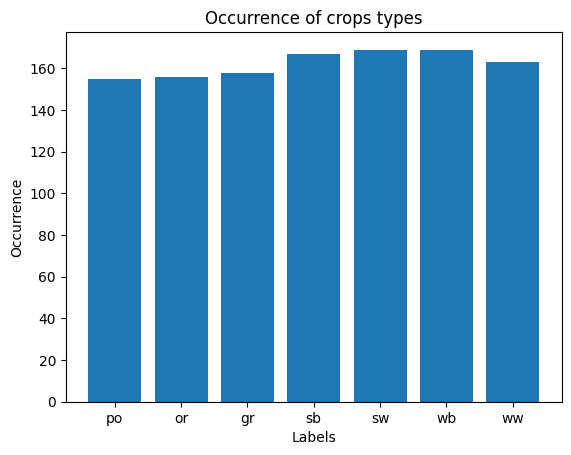

dict_keys(['po', 'or', 'gr', 'sb', 'sw', 'wb', 'ww'])
dict_values([155, 156, 158, 167, 169, 169, 163])

Choose an interval
lower limit
4
upper limit at 10%
4
{'po': 4, 'or': 4, 'gr': 4, 'sb': 4, 'sw': 4, 'wb': 4, 'ww': 4, 'ot': 0}


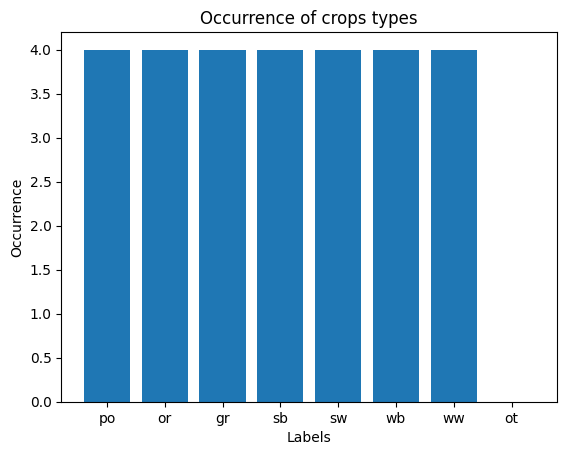

100% (1137 of 1137) |####################| Elapsed Time: 0:05:36 ETA:  00:00:00

In [8]:
data = equalize(dataset)

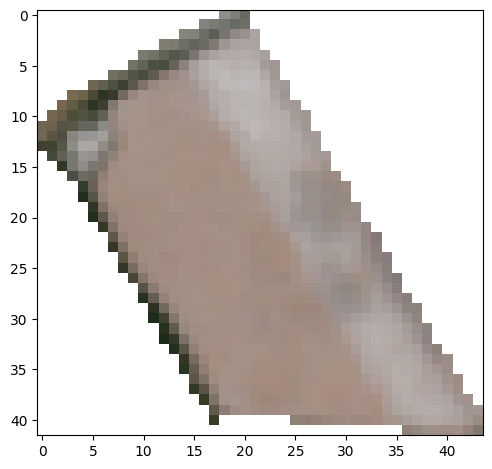

In [9]:
data['cropcode'][0]
imshow(data['image'][0][:, :, [3, 2, 1, 7]]/2**12)

In [10]:
np.savez("DataSet/data_25_01_reduced.npz", image=data['image'], cropcode=data['cropcode'])

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
